## Get the lever position for every data row of the ses.ap.pose 


The lever position was extracted by DLC running on the `arena_top_cropped.mp4` and the values are stored in `mouseLeverPosition.csv`.
We can use `arena_top.log` to get the ROS time of the frames.

3 body parts were tracked, leading to 6 data points : leverPressX,leverPressY,leverBoxPLX,leverBoxPLY,leverBoxPRX,leverBoxPRY

For making the analysis easier, I will get the position of these 3 body parts at the same time points as the ses.ap.pose matrix. In addition, we will change the reference frame so that the arena center is at 0,0 and that the data are in cm.


In [1]:
%load_ext autoreload
%autoreload 2
%run setup_project.py
prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList)

Project name: autopi_ca1
dataPath: /adata/projects/autopi_ca1
dlcModelPath: /adata/models
Reading /adata/projects/autopi_ca1/sessionList
We have 44 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|███████████████████████████████████████████| 44/44 [00:42<00:00,  1.05it/s]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [2]:
sSes = sSesList[43]
ses = myProject.sessionList[43]
print(sSes.name,sSes.path)

mn9686-01112021-0106 /adata/projects/autopi_ca1/mn9686/mn9686-01112021-0106


Set this lever position analysis to run on all our recording sessions

In [4]:
from PIL import Image
def createLeverPoseFile(ses):
    posLev = pd.read_csv(ses.path+"/"+ses.name+".mouseLeverPosition.csv")
    ti = pd.read_csv(ses.path+"/"+ses.name+".arena_top.log",sep=" ")
    posLev["rosTime"]= ti.time
    
    logRosTimeRange = np.array([np.nanmin(posLev.rosTime),np.nanmax(posLev.rosTime)])
   # print("Video ros time: {}, {}".format(np.nanmin(posLev.rosTime),np.nanmax(posLev.rosTime)))
    
    
    arenaImageFile=ses.path+"/arenaDetectionCropped.png"
    im = Image.open(arenaImageFile)
    plt.imshow(im)
    aCoord = np.loadtxt(ses.path+"/arenaCoordinates")
    #plt.scatter(aCoord[0],aCoord[1])
    #plt.show()
    
    posLev.leverPressX=(posLev.leverPressX-aCoord[0])/aCoord[2]*40
    posLev.leverPressY=(posLev.leverPressY-aCoord[1])/aCoord[2]*40
    posLev.leverBoxPLX=(posLev.leverBoxPLX-aCoord[0])/aCoord[2]*40
    posLev.leverBoxPLY=(posLev.leverBoxPLY-aCoord[1])/aCoord[2]*40
    posLev.leverBoxPRX=(posLev.leverBoxPRX-aCoord[0])/aCoord[2]*40
    posLev.leverBoxPRY=(posLev.leverBoxPRY-aCoord[1])/aCoord[2]*40
    
    # model
    lpx = interp1d(posLev.rosTime,posLev.leverPressX,bounds_error=False)
    lpy = interp1d(posLev.rosTime,posLev.leverPressY,bounds_error=False)
    lblx = interp1d(posLev.rosTime,posLev.leverBoxPLX,bounds_error=False)
    lbly = interp1d(posLev.rosTime,posLev.leverBoxPLY,bounds_error=False)
    lbrx = interp1d(posLev.rosTime,posLev.leverBoxPRX,bounds_error=False)
    lbry = interp1d(posLev.rosTime,posLev.leverBoxPRY,bounds_error=False)

    # interpolate
    apRosTimeRange = np.array([np.nanmin(ses.ap.pose[:,7]),np.nanmax(ses.ap.pose[:,7])])
    #print("Animal pose ros time: {}, {}".format(np.nanmin(ses.ap.pose[:,7]),np.nanmax(ses.ap.pose[:,7])))
    
    print("{}, time difference ap, log: {}".format(ses.name,logRosTimeRange-apRosTimeRange))
    plpx = lpx(ses.ap.pose[:,7])
    plpy = lpy(ses.ap.pose[:,7])
    plblx = lblx(ses.ap.pose[:,7])
    plbly = lbly(ses.ap.pose[:,7])
    plbrx = lbrx(ses.ap.pose[:,7])
    plbry = lbry(ses.ap.pose[:,7])

    leverPose = pd.DataFrame({"time":ses.ap.pose[:,7],
                              "timeRec":ses.ap.pose[:,0],
                          "leverPressX":plpx,
                          "leverPressY":plpy,
                          "leverBoxPLX":plblx,
                          "leverBoxPLY":plbly,
                          "leverBoxPRX":plbrx,
                          "leverBoxPRY":plbry})
    
    leverPose.to_csv(ses.path+"/leverPose",index=False)

mn9686-01112021-0106, time difference ap, log: [3570.98506951  -32.47790694]


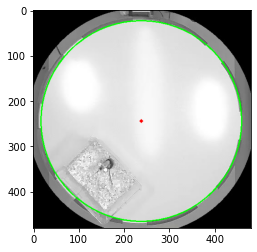

In [5]:
createLeverPoseFile(sSes)

mn5824-20112020-0107, time difference ap, log: [ -109.06950831 -1404.53839302]
mn5824-22112020-0107, time difference ap, log: [  -42.98616195 -1298.07645321]
mn5824-24112020-0107, time difference ap, log: [  -39.20208192 -1298.91354132]
mn5824-02122020-0106, time difference ap, log: [  -36.32158995 -1381.99310255]
mn711-28012021-0106, time difference ap, log: [-105.0815289     0.21755433]
mn711-30012021-0106, time difference ap, log: [-38.71044302 333.75631428]
mn711-31012021-0107, time difference ap, log: [-31.14655757   0.26630616]
mn711-01022021-0107, time difference ap, log: [-32.71340203   0.21440434]
mn711-02022021-0108, time difference ap, log: [-29.46223044   0.27158999]
mn711-03022021-0107, time difference ap, log: [-32.27311969   0.17686439]
mn711-04022021-0107, time difference ap, log: [-13.67358088   0.22515798]
mn2739-11022021-0107, time difference ap, log: [-53.97991943   0.15982556]
mn2739-15022021-0105, time difference ap, log: [-39.86168766   5.79759216]
mn2739-1602202

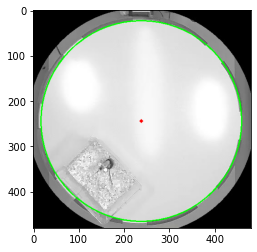

In [35]:
for sSes in sSesList:
    createLeverPoseFile(sSes)